In [14]:
# https://www.kaggle.com/zetha82/exercise-word-vectors/edit
# https://www.machinelearningplus.com/nlp/cosine-similarity/
import os
import sys
import pandas as pd
import numpy as np
import csv
import re
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
# save numpy array 
from numpy import save
# load numpy array 
from numpy import load

# sklearn knižnice
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# gensim knižnice
import gensim
from gensim.matutils import softcossim 
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess

cwd = os.getcwd()

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/insAInDev_Tools/')
import insAInDev_Processor as insAIProc

# fasttext facebook knižnica
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')


# inicializácia nlp
# Load the large model to get the vectors
# LINK pre instalaciu https://spacy.io/models/en
nlp = spacy.load('en_core_web_lg')

### Načítanie datasetu

In [3]:
# nastavenie vizualizácie full text length
pd.set_option('display.max_colwidth', -1)

# separátor stĺpcov sa používa čiarka (pre tab to je sep='\t')
# quoting=3 je pre odstránenie úvodzoviek v texte 
df = pd.read_csv(cwd + '/Datasets/YelpRatings/yelp_ratings.csv')

# zobrazenie prvých 3 riadkov 
df.head(3)

<ipython-input-3-1a240441b50f>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Review,Stars,Sentiment
0,Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.,1.0,0
1,"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon! I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level! \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit. Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room. Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure. That was superb! Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen. The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement. It was so much fun to be there! \n\nNext Travis started with the flat iron. The way he flipped his wrist to get volume all around without over-doing it and making me look like a Texas pagent girl was admirable. It's also worth noting that he didn't fry my hair -- something that I've had happen before with less skilled stylists. At the end of the blowout & style my hair was perfectly bouncey and looked terrific. The only thing better? That this awesome blowout lasted for days! \n\nTravis, I will see you every single time I'm out in Vegas. You make me feel beauuuutiful!",5.0,1
2,"I have to say that this office really has it together, they are so organized and friendly! Dr. J. Phillipp is a great dentist, very friendly and professional. The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable! I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit! I highly recommend this office for the nice synergy the whole office has!",5.0,1


### Konkretizácia dát

In [15]:
# pomenovanie stĺpcov z datasetu
col = ['Review', 'Sentiment']
# pridelenie stĺpcov z dataframeu
df = df[col]
# úprava datasetu (vymazanie riadkov s prázdnym textom)
df = df[pd.notnull(df['Review'])]
# definovanie konkrtétnych stĺpcov z dataframeu
df.columns = ['Review', 'Sentiment']

### Vizualizácia v grafe

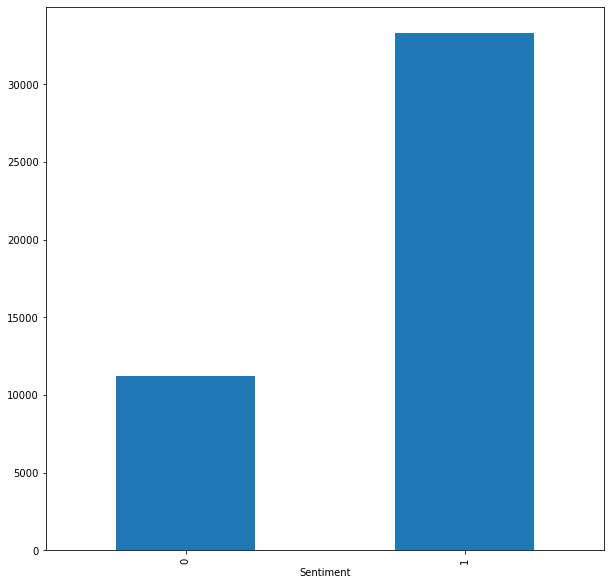

In [16]:
# definovanie veľkosti grafu
fig = plt.figure(figsize=(10,10))

# zoskupenie počtu recenzii rozdelené podľa Liked
df.groupby('Sentiment').Review.count().plot.bar(ylim=0)

# zobrazenie grafu
plt.show()

### Práca so STOPWORDS a Vektorizácia

In [17]:
cleanedCorpus = insAIProc.removeStopwordfromDataframeColumn(df,'not')

# inicializácia vektorizácie
cv = TfidfVectorizer(max_features = 300)
# inicializácie features a labels
features = cv.fit_transform(cleanedCorpus).toarray()
labels = df.Sentiment

print(features.shape)

(44530, 300)


### Uloženie vektorov do súboru

In [18]:
with open(cwd + '/Datasets/YelpRatings/cleaned_vectors.npy', 'wb') as f:
    np.save(f, vectors)

### Načítanie vektorov zo súboru

In [19]:
# Loading all document vectors from file
vectors = np.load(cwd + '/Datasets/YelpRatings/cleaned_vectors.npy')

### Rozdelenie datasetu (training, test)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

### Tréning modelu

In [21]:
# Create the LinearSVC model
model = LinearSVC(random_state=1, dual=False)
# Fit the model
model.fit(X_train, y_train)

# Uncomment and run to see model accuracy
print(f'Model test accuracy: {model.score(X_test, y_test)*100:.3f}%')

Model test accuracy: 90.366%


### Funkcia na výpočet podobnosti

In [22]:
def cosine_similarity(a, b):
    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))

### Skúška podobnosti

In [23]:
# inicializácia dummy test vety
review = """I absolutely love this place. The 360 degree glass windows with the 
Yerba buena garden view, tea pots all around and the smell of fresh tea everywhere 
transports you to what feels like a different zen zone within the city. I know 
the price is slightly more compared to the normal American size, however the food 
is very wholesome, the tea selection is incredible and I know service can be hit 
or miss often but it was on point during our most recent visit. Definitely recommend!

I would especially recommend the butternut squash gyoza."""

# Vektorizácia test vety do spacy
review_vec = nlp(review).vector

# Výpočet priemeru vektorov
vec_mean = vectors.mean(axis=0)
# Subtract the mean from the vectors
centered = vectors - vec_mean

# Výpočet podobnosti pre každý dokument v množine údajov
# Odčítanie vektoru od priemeru
sims = np.array([cosine_similarity(review_vec - vec_mean, vec) for vec in centered])

# Získanie indexu pre najpodobnejší dokument
most_similar = sims.argmax()

# Zobrazenie podobnosti
print(most_similar)

52


### Zobrazenie najviac podobného textu

In [24]:
print(df.iloc[most_similar].Review)

There is a reason I frequent Paul's Ace over the big names such as Home Depot or Lowes: the personalized assistance. Do the big name brands provide this? Yes, bit not at the same level Paul's Ace Hardware does in Tempe. If I need help, they are ready and willing to help me in every aspect of my project.

The store manager Bras personally went out if his way to assist me in gathering all the materials I needed for my current project. He knows his store, bounced around to show me all options, and seemed to have recommendations on each project. This guy must love what he does because he knows everything in the store (or he is a constant do-it-yourselfer).

I am always pleased with the help I receive and am thankful this place is in my neighborhood.


### Priklad mimo dema

In [28]:
# Dokumenty zamerane na politiku
doc_trump = "Mr. Trump became president after winning the political election. Though he lost the support of some republican friends, Trump is friends with President Putin"

doc_election = "President Trump says Putin had no political interference is the election outcome. He says it was a witchhunt by political parties. He claimed President Putin is a friend who had nothing to do with the election"

doc_putin = "Post elections, Vladimir Putin became President of Russia. President Putin had served as the Prime Minister earlier in his political career"

# Dokument zamerane na jedlo
doc_soup = "Soup is a primarily liquid food, generally served warm or hot (but may be cool or cold), that is made by combining ingredients of meat or vegetables with stock, juice, water, or another liquid. "

doc_noodles = "Noodles are a staple food in many cultures. They are made from unleavened dough which is stretched, extruded, or rolled flat and cut into one of a variety of shapes."

doc_dosa = "Dosa is a type of pancake from the Indian subcontinent, made from a fermented batter. It is somewhat similar to a crepe in appearance. Its main ingredients are rice and black gram."

politics_documents = [doc_trump, doc_election, doc_putin]
food_documents = [doc_soup, doc_noodles, doc_dosa]


# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(politics_documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
politics_df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['doc_trump', 'doc_election', 'doc_putin'])
print(politics_df)


sparse_matrix2 = count_vectorizer.fit_transform(food_documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix2.todense()
food_df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['doc_soup', 'doc_noodles', 'doc_dosa'])
print(food_df)

              after  as  became  by  career  claimed  do  earlier  election  \
doc_trump     1      0   1       0   0       0        0   0        1          
doc_election  0      0   0       1   0       1        1   0        2          
doc_putin     0      1   1       0   1       0        0   1        0          

              elections  ...  the  though  to  trump  vladimir  was  who  \
doc_trump     0          ...  2    1       0   2      0         0    0     
doc_election  0          ...  2    0       1   1      0         1    1     
doc_putin     1          ...  1    0       0   0      1         0    0     

              winning  witchhunt  with  
doc_trump     1        0          1     
doc_election  0        1          1     
doc_putin     0        0          0     

[3 rows x 48 columns]
             and  another  appearance  are  batter  be  black  but  by  cold  \
doc_soup     0    1        0           0    0       1   0      1    1   1      
doc_noodles  1    0        0   

### Cosine similarity politics

In [30]:
print(cosine_similarity(politics_df, politics_df))

[[1.         0.51480485 0.38890873]
 [0.51480485 1.         0.38829014]
 [0.38890873 0.38829014 1.        ]]


### Cosine similarity food

In [31]:
print(cosine_similarity(food_df, food_df))

[[1.         0.25253814 0.17407766]
 [0.25253814 1.         0.3385016 ]
 [0.17407766 0.3385016  1.        ]]


### Soft cosine similarity

In [27]:
mixed_documents = [doc_trump, doc_election, doc_putin, doc_soup, doc_noodles, doc_dosa]

# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in mixed_documents])

# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

# Convert the sentences into bag-of-words vectors.
sent_1 = dictionary.doc2bow(simple_preprocess(doc_trump))
sent_2 = dictionary.doc2bow(simple_preprocess(doc_election))
sent_3 = dictionary.doc2bow(simple_preprocess(doc_putin))
sent_4 = dictionary.doc2bow(simple_preprocess(doc_soup))
sent_5 = dictionary.doc2bow(simple_preprocess(doc_noodles))
sent_6 = dictionary.doc2bow(simple_preprocess(doc_dosa))

sentences = [sent_1, sent_2, sent_3, sent_4, sent_5, sent_6]

print(softcossim(sent_1, sent_2, similarity_matrix))


def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

create_soft_cossim_matrix(sentences)

<ipython-input-27-df20c0758515>:7: DeprecationWarning: Call to deprecated `similarity_matrix` (Method will be removed in 4.0.0, use gensim.models.keyedvectors.WordEmbeddingSimilarityIndex instead).
  similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)


0.5842470143211804


<ipython-input-27-df20c0758515>:19: DeprecationWarning: Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).
  print(softcossim(sent_1, sent_2, similarity_matrix))
<ipython-input-27-df20c0758515>:25: DeprecationWarning: Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).
  cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])


,0,1,2,3,4,5
0,1.00,0.58,0.56,0.28,0.34,0.40
1,0.58,1.00,0.54,0.25,0.31,0.43
2,0.56,0.54,1.00,0.19,0.25,0.36
3,0.28,0.25,0.19,1.00,0.50,0.38
4,0.34,0.31,0.25,0.50,1.00,0.56
5,0.40,0.43,0.36,0.38,0.56,1.00
